<a href="https://colab.research.google.com/github/DommiiUdomp/water-station/blob/main/earthquakes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas
!pip install contextily
!pip install geoplot

In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import contextily as cx
import geoplot

# ***Explore Data***

In [ ]:
!wget 'https://d32ogoqmya1dw8.cloudfront.net/files/NAGTWorkshops/intro/activities/Continents.zip'

In [ ]:
!wget 'https://data.humdata.org/dataset/4881d82b-ba63-4515-b748-c364f3d05b42/resource/10ac8776-5141-494b-b3cd-bf7764b2f964/download/earthquakes1970-2014.csv'

In [ ]:
!unzip '/content/Continents.zip'

(8, 5)


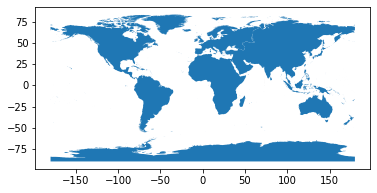

In [10]:
continents = gpd.read_file('/content/Continents/continents.shp')
print(continents.shape)
continents.plot()

In [11]:
continents.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [135]:
earthquakes = pd.read_csv('/content/earthquakes1970-2014.csv')
earthquakes.head()

,DateTime,Latitude,Longitude,Depth,Magnitude,MagType,NbStations,Gap,Distance,RMS,Source,EventID
0,1970/01/04 17:00:40.20,24.139,102.503,31.0,7.5,Ms,90.0,NaN,NaN,0.0,NEI,1.970010e+09
1,1970/01/06 05:35:51.80,-9.628,151.458,8.0,6.2,Ms,85.0,NaN,NaN,0.0,NEI,1.970011e+09
2,1970/01/08 17:12:39.10,-34.741,178.568,179.0,6.1,Mb,59.0,NaN,NaN,0.0,NEI,1.970011e+09
3,1970/01/10 12:07:08.60,6.825,126.737,73.0,6.1,Mb,91.0,NaN,NaN,0.0,NEI,1.970011e+09
4,1970/01/16 08:05:39.00,60.280,-152.660,85.0,6.0,ML,0.0,NaN,NaN,NaN,AK,NaN


In [136]:
earthquakes.drop(columns=['Gap','Source','EventID','Distance','RMS'],inplace =True)

In [79]:
earthquakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5304 entries, 0 to 5303
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DateTime    5304 non-null   object 
 1   Latitude    5304 non-null   float64
 2   Longitude   5304 non-null   float64
 3   Depth       5304 non-null   float64
 4   Magnitude   5304 non-null   float64
 5   MagType     5304 non-null   object 
 6   NbStations  5250 non-null   float64
dtypes: float64(5), object(2)
memory usage: 290.2+ KB


In [80]:
earthquakes['NbStations'].fillna(method='ffill',inplace=True)
print(earthquakes['NbStations'].isna().sum())

0


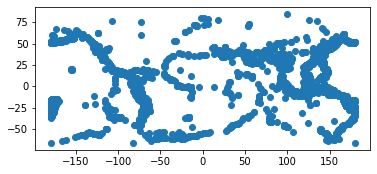

In [81]:
earthquakes_gdf = gpd.GeoDataFrame(earthquakes, geometry=gpd.points_from_xy(earthquakes.Longitude, earthquakes.Latitude), crs="EPSG:4326")
earthquakes_gdf.plot()

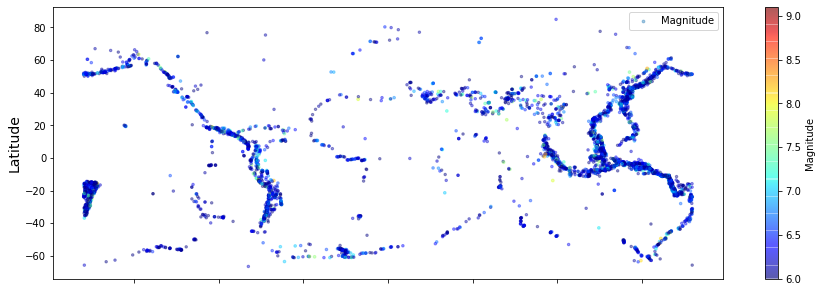

In [70]:
earthquakes.plot(kind='scatter', x='Longitude', y='Latitude', alpha=0.4,
				s=earthquakes['Magnitude'], label='Magnitude', figsize=(15,5),
				c='Magnitude', cmap=plt.get_cmap('jet'), colorbar=True)

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend() 
plt.show()

# ***Geoplot***

/usr/local/lib/python3.7/dist-packages/geoplot/geoplot.py:885: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


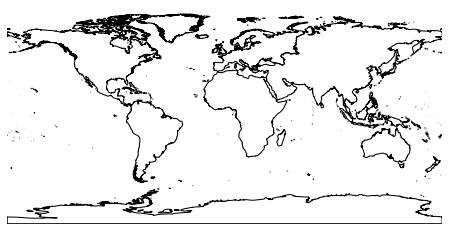

In [17]:
geoplot.polyplot(continents, figsize=(8, 4))

/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 9
  Warn("Warning: setting k to %d" % k_q, UserWarning)
/usr/local/lib/python3.7/dist-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 19 is not valid for the current tile provider (valid zooms: 1 - 16).
  warnings.warn(msg)


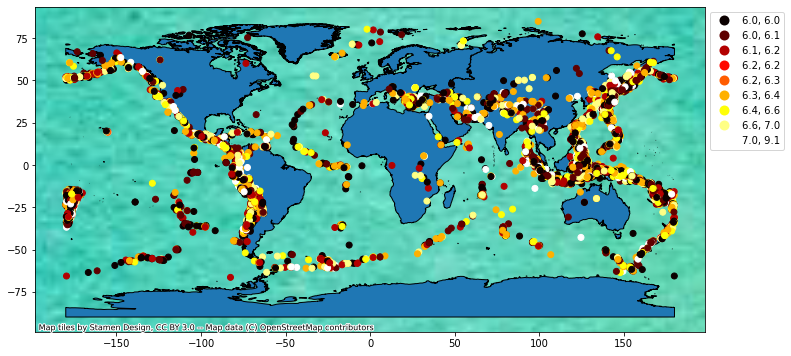

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), edgecolor='k')
continents.plot(ax=ax, edgecolor='black')
earthquakes_gdf.plot(column= 'Magnitude', scheme='QUANTILES', cmap=plt.cm.hot, k=10, legend=True, 
                     legend_kwds={'bbox_to_anchor':(1,1) ,'fmt': "{:.1f}"}, ax=ax)

cx.add_basemap(ax, source=cx.providers.Stamen.Watercolor)
plt.show()

In [19]:
# lat and lon to numeric, errors converted to nan
#earthquakes['Longitude'] = pd.to_numeric(earthquakes.Longitude, errors='coerce')
#earthquakes['Latitude'] = pd.to_numeric(earthquakes.Latitude, errors='coerce')

# ***Ploty***

In [139]:
earthquakes_df = earthquakes.iloc[:,:-1]
earthquakes_df[['year','month','day']] = earthquakes['DateTime'].str.split('/',expand=True)

In [142]:
earthquakes_df[['day','s']] = earthquakes_df['day'].str.split(' ',expand=True)

In [158]:
earthquakes_df[['datetime','s']] = earthquakes_df['DateTime'].str.split(' ',expand=True)

In [159]:
earthquakes_df.head(2)

,DateTime,Latitude,Longitude,Depth,Magnitude,MagType,year,month,day,s,datetime
0,1970/01/04 17:00:40.20,24.139,102.503,31.0,7.5,Ms,1970,01,04,17:00:40.20,1970/01/04
1,1970/01/06 05:35:51.80,-9.628,151.458,8.0,6.2,Ms,1970,01,06,05:35:51.80,1970/01/06


In [92]:
import plotly.express as px

In [125]:
fig = px.scatter_mapbox(earthquakes_df, lon='Longitude', lat='Latitude', width = 1000, height=600, hover_data=['Magnitude'])
fig.update_layout(mapbox_style='open-street-map')
fig.show()

In [169]:
fig = px.scatter_mapbox(earthquakes_df, lon='Longitude', lat='Latitude', animation_frame='year', animation_group="Magnitude",
           size="Depth", size_max=55, color="Magnitude",hover_name="Magnitude",hover_data=['Magnitude'])

#fig = px.scatter_mapbox(earthquakes_df, lon='Longitude', lat='Latitude', width = 1000, height=600, hover_data=['Magnitude'])
fig.update_layout(mapbox_style='open-street-map')
fig.show()

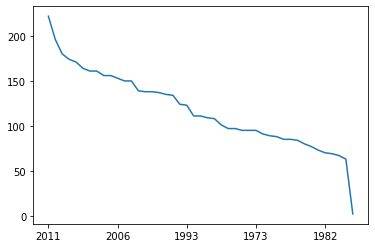

In [167]:
earthquakes_df['year'].value_counts().plot()

In [116]:
earthquakes_df['DateTime'] = pd.to_datetime(earthquakes_df.iloc[:,7:10])

In [118]:
earthquakes_df.drop(columns=['Year',	'Month',	'Day',	'S'],inplace=True)

In [119]:
earthquakes_df.head(2)

,DateTime,Latitude,Longitude,Depth,Magnitude,MagType,NbStations
0,1970-01-04,24.139,102.503,31.0,7.5,Ms,90.0
1,1970-01-06,-9.628,151.458,8.0,6.2,Ms,85.0


In [132]:
earthquakes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5304 entries, 0 to 5303
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DateTime    5304 non-null   datetime64[ns]
 1   Latitude    5304 non-null   float64       
 2   Longitude   5304 non-null   float64       
 3   Depth       5304 non-null   float64       
 4   Magnitude   5304 non-null   float64       
 5   MagType     5304 non-null   object        
 6   NbStations  5250 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 290.2+ KB


In [96]:
#pd.to_datetime(earthquakes['DateTime'], errors='coerce',infer_datetime_format=True).isna().sum() format='%Y%m%d'

0

# ***Data Preparation***

In [23]:
earthquakes['Magnitude'].unique().round(0)

array([8., 6., 6., 6., 6., 6., 7., 7., 7., 7., 7., 7., 6., 8., 7., 8., 8.,
       8., 7., 7., 8., 8., 7., 8., 6., 7., 6., 7., 6., 6., 7., 8., 6., 6.,
       8., 9., 9., 8., 9., 9.])

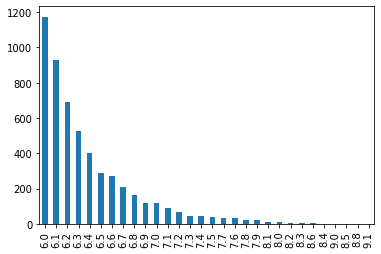

In [24]:
#SET Major earthquake 
earthquakes['Magnitude'].round(1).value_counts().plot(kind='bar')

In [25]:
earthquakes['Magnitude'] = earthquakes['Magnitude'].round(1)

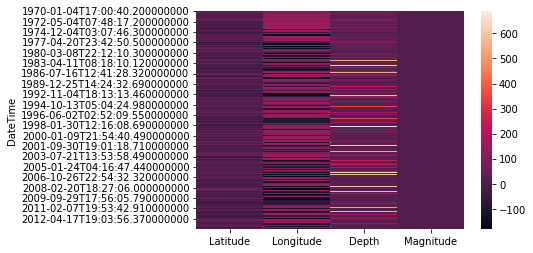

In [53]:
data = earthquakes.iloc[:,:4]
sns.heatmap(data)

In [27]:
data['Magnitude'].corr(data['Depth'])

0.01298769255958674

# ***Resample***

In [49]:
data['Magnitude'].resample('6M').max()

DateTime
1970-01-31    7.5
1970-07-31    7.8
1971-01-31    8.1
1971-07-31    7.9
1972-01-31    7.8
             ... 
2012-01-31    7.4
2012-07-31    8.6
2013-01-31    7.8
2013-07-31    8.3
2014-01-31    7.7
Freq: 6M, Name: Magnitude, Length: 89, dtype: float64

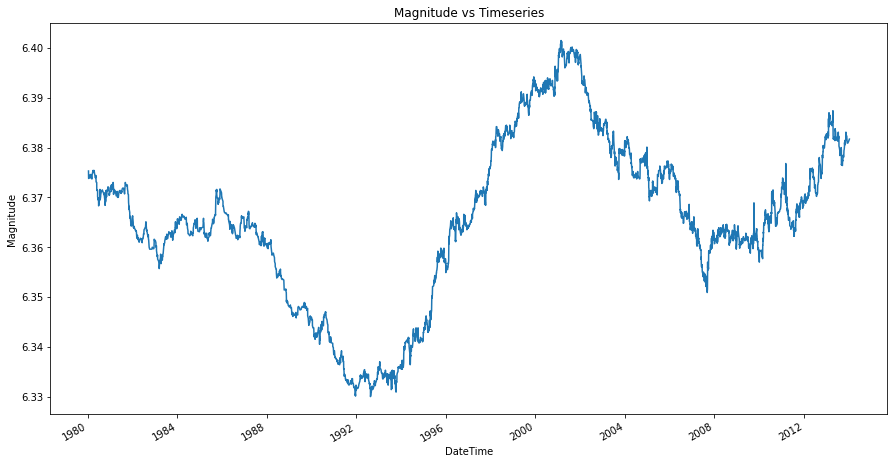

In [173]:
fig,ax=plt.subplots(figsize=(15,8))
data['Magnitude'].rolling(1000).mean().plot(ax=ax, ylabel='Magnitude', title='Magnitude vs Timeseries')

# ***Isolation Forest***

In [29]:
from sklearn.ensemble import IsolationForest

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


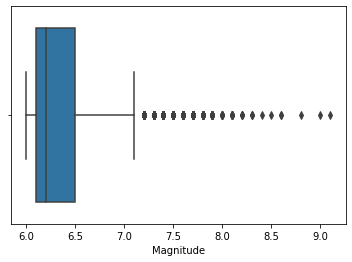

In [30]:
sns.boxplot(data.Magnitude)

In [63]:
model=IsolationForest(n_estimators=100,max_samples='auto',contamination=float(0.2),random_state=np.random.RandomState(42))
model.fit(data[['Magnitude']])
print(model.get_params())
data['scores'] = model.decision_function(data[['Magnitude']])
data['anomaly_score'] = model.predict(data[['Magnitude']])
print(data[data['anomaly_score']==-1].head())

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


{'bootstrap': False, 'contamination': 0.2, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': RandomState(MT19937) at 0x7FCB86C99380, 'verbose': 0, 'warm_start': False}
                         Latitude  Longitude  Depth  Magnitude    scores  \
DateTime                                                                   
1970-01-04 17:00:40.200    24.139    102.503   31.0        7.5 -0.133626   
1970-03-27 18:36:45.800     0.370    119.349    8.0        6.7 -0.003468   
1970-03-28 21:02:23.400    39.182     29.488   20.0        7.1 -0.067555   
1970-04-07 05:34:05.600    15.761    121.717   37.0        7.3 -0.125362   
1970-04-12 04:01:44.000    15.064    122.052   24.0        7.0 -0.048888   

                         anomaly_score  
DateTime                                
1970-01-04 17:00:40.200             -1  
1970-03-27 18:36:45.800             -1  
1970-03-28 21:02:23.400             -1  
1970-04-07 05:34:05.600             -1  
1970-0

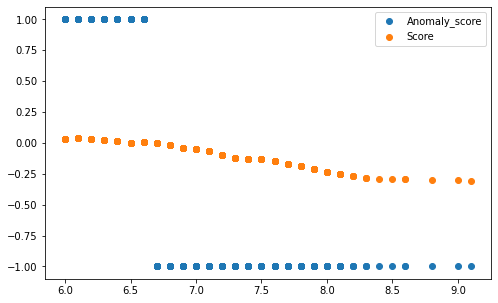

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
plt.scatter(data["Magnitude"], data['anomaly_score'], label="Anomaly_score")
plt.scatter(data["Magnitude"], data['scores'], label="Score")
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


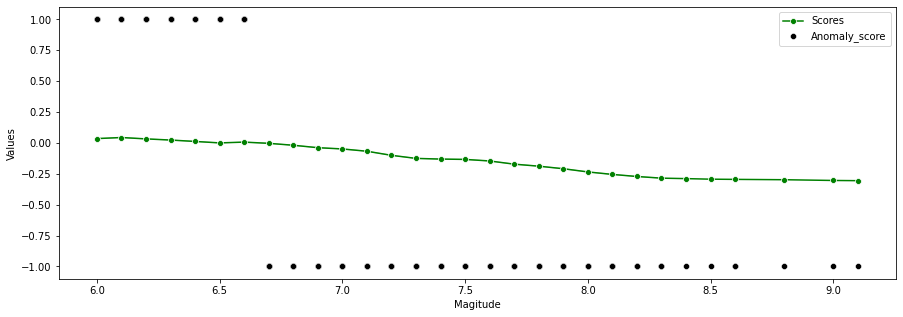

In [57]:
plt.figure(figsize=(15,5))

plt.xlabel('Magitude')
plt.ylabel('Values')

sns.scatterplot(data["Magnitude"], data['anomaly_score'], label="Anomaly_score", color='black')
sns.lineplot(data["Magnitude"], data['scores'] , marker = 'o', color='green', label= 'Scores')

plt.legend()

In [58]:
accuracy = 100*list(data['anomaly_score']).count(-1)/(data['anomaly_score'].value_counts().sum())
print("Accuracy of the model:", accuracy)

Accuracy of the model: 19.287330316742082


# ***Anomaly detection AutoEncoder***

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

# ***Location***

In [40]:
locations_to_show_on_map = ["University of Szeged"]
uni_location = gpd.tools.geocode(locations_to_show_on_map, provider='nominatim', user_agent="maksym demo")
print(uni_location)

                    geometry  \
0  POINT (20.14649 46.25005)   

                                             address  
0  Szegedi Tudományegyetem, 13, Dugonics tér, Bel...  


In [42]:
uni_location.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [41]:
locations_to_show_on_map = ["Phuket Island"]
phuket_location = gpd.tools.geocode(locations_to_show_on_map, provider='nominatim', user_agent="maksym demo")
print(phuket_location)

                    geometry  \
0  POINT (18.09097 59.30361)   

                                             address  
0  Phuket Island, Hammarby Allé, Skanstull, Södra...  
